# LLC matched to MODIS -- Developing

In [144]:
# imports
from importlib import reload

import os
import numpy as np
import datetime

import pandas
import xarray
import h5py

from matplotlib import pyplot as plt
import seaborn as sns

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.models import io as model_io
from ulmo.modis import io as modis_io
from ulmo.utils import catalog as cat_utils
from ulmo.preproc import plotting as pp_plotting

from astropy import units
from astropy.coordinates import SkyCoord, match_coordinates_sky


# Init

In [2]:
field_size=(64,64)

In [3]:
CC_max = 1e-4

# Load

## LLC

In [5]:
reload(llc_io)
CC_mask = llc_io.load_CC_mask(field_size=field_size, 
                                  local=True)

Loading LLC CC mask from /data/Projects/Oceanography/data/LLC/CC/LLC_CC_mask_64.nc


In [6]:
CC_mask

<xarray.Dataset>
Dimensions:  (x: 12960, y: 17280)
Coordinates:
    lon      (x, y) float32 ...
    lat      (x, y) float32 ...
Dimensions without coordinates: x, y
Data variables:
    CC_mask  (x, y) float64 ...

## MODIS

In [14]:
tbl_file = 's3://modis-l2/Tables/MODIS_L2_std.feather' # A bit slow via s3
modisl2_table = ulmo_io.load_main_table(tbl_file)

Read main table: s3://modis-l2/Tables/MODIS_L2_std.feather


# Coords

In [7]:
# Cut
good_CC = CC_mask.CC_mask.values < CC_max
good_CC_idx = np.where(good_CC)

# Build coords
llc_lon = CC_mask.lon.values[good_CC].flatten()
llc_lat = CC_mask.lat.values[good_CC].flatten()
print("Building LLC SkyCoord")
llc_coord = SkyCoord(llc_lon*units.deg + 180.*units.deg, 
                     llc_lat*units.deg, 
                     frame='galactic')

Building LLC SkyCoord


In [31]:
np.max(np.abs(llc_lat))

78.13409

In [8]:
del CC_mask

# Times available

## Grab files

In [147]:
reload(ulmo_io)
llc_files = np.array(ulmo_io.list_of_bucket_files('llc', prefix='/ThetaUVSalt'))

## Times

In [148]:
times = [os.path.basename(ifile)[8:-3].replace('_',':') for ifile in llc_files]
times[0:3]

['2011-09-13T00:00:00', '2011-09-13T01:00:00', '2011-09-13T02:00:00']

In [61]:
llc_dti = pandas.to_datetime(times)

In [62]:
len(llc_dti)

875

# Grid

In [63]:
llc_grid = np.zeros((len(llc_coord), len(llc_dti)), dtype=bool)

In [64]:
llc_grid.size

100803465000

# 2012 MODIS

## Cut

In [17]:
modisl2_table.pp_file[0]

's3://modis-l2/PreProc/MODIS_R2019_2003_95clear_128x128_preproc_std.h5'

In [19]:
y2012 = modisl2_table.pp_file == 's3://modis-l2/PreProc/MODIS_R2019_2012_95clear_128x128_preproc_std.h5'
np.sum(y2012)

730634

### LLC is not all of 2012

In [83]:
in_llc = modisl2_table.datetime < llc_dti.max()

In [84]:
modis_2012 = modisl2_table.loc[y2012&in_llc].copy()

In [87]:
modis_2012.datetime.max()

Timestamp('2012-11-15 11:35:00')

## Coords

In [88]:
modis_coord = SkyCoord(modis_2012.lon.values*units.deg + 180.*units.deg, 
                     modis_2012.lat.values*units.deg, 
                     frame='galactic')

In [89]:
modis_coord

<SkyCoord (Galactic): (l, b) in deg
    [(217.615513, -18.549124), (199.459482,  34.162098),
     (207.425474,  32.603806), ..., (208.637428,  34.018723),
     (195.779327,  35.945026), (130.253048,  57.483936)]>

## Match in space

In [90]:
idx, sep2d, _ = match_coordinates_sky(modis_coord, llc_coord, nthneighbor=1)

In [91]:
np.max(sep2d).to('deg')

<Angle 14.9173047 deg>

In [92]:
imx = np.argmax(sep2d)

In [93]:
modis_2012.iloc[imx]

lat                                                            79.675
lon                                                           111.636
col                                                               517
datetime                                          2012-09-08 03:10:00
LL                                                            117.078
row                                                               267
clear_fraction                                              0.0494995
mean_temperature                                             0.281722
Tmin                                                           -0.895
Tmax                                                            1.435
T90                                                              1.14
T10                                                             -0.66
filename                         AQUA_MODIS.20120908T031008.L2.SST.nc
UID                                               1347169675029163565
pp_file             

In [94]:
#sns.jointplot(x=sep2d.to('deg').value, y=modis_coord.galactic.b.deg)

## Match in time

### Convert to hours from 2012-01-01 00:00:00

In [95]:
modis_2012['dt'] = modis_2012.datetime - pandas.Timestamp('2012-01-01')

In [97]:
hours = np.round(modis_2012.dt.values / np.timedelta64(1, 'h')).astype(int)
#hours[0:10]
modis_2012['hours'] = hours

### Round to every 12 hours

In [98]:
hours.min()

1

In [99]:
hour_12 = 12*np.round(hours / 12).astype(int)
hour_12

array([2352, 4128, 5640, ..., 5040, 4344, 1944])

In [100]:
hours[:5], hour_12[:5]

(array([2351, 4129, 5640, 2974, 6423]), array([2352, 4128, 5640, 2976, 6420]))

In [101]:
modis_2012['hour_12'] = hour_12

### LLC

In [102]:
llc_hours = np.round((llc_dti-pandas.Timestamp('2012-01-01')).values / np.timedelta64(1, 'h')).astype(int)

In [103]:
llc_hours[:10]

array([-2640, -2639, -2638, -2637, -2636, -2635, -2634, -2633, -2632,
       -2631])

In [104]:
llc_dti-pandas.Timestamp('2012-01-01')

TimedeltaIndex(['-110 days +00:00:00', '-110 days +01:00:00',
                '-110 days +02:00:00', '-110 days +03:00:00',
                '-110 days +04:00:00', '-110 days +05:00:00',
                '-110 days +06:00:00', '-110 days +07:00:00',
                '-110 days +08:00:00', '-110 days +09:00:00',
                ...
                  '315 days 00:00:00',   '315 days 12:00:00',
                  '316 days 00:00:00',   '316 days 12:00:00',
                  '317 days 00:00:00',   '317 days 12:00:00',
                  '318 days 00:00:00',   '318 days 12:00:00',
                  '319 days 00:00:00',   '319 days 12:00:00'],
               dtype='timedelta64[ns]', length=875, freq=None)

### Match

In [108]:
mt_t = cat_utils.match_ids(hour_12, llc_hours)#, require_in_match=False)

In [119]:
mt_t.max(), mt_t.min()

(874, 235)

In [110]:
idx.min()

922367

## Assign

In [112]:
tot_idx = idx*1000 + mt_t

In [118]:
complete = np.zeros(tot_idx.size, dtype=bool)

In [116]:
uval, uidx = np.unique(tot_idx, return_index=True)

In [117]:
uidx.size, tot_idx.size

(635295, 647738)

## Update grid

In [120]:
llc_grid[idx[uidx], mt_t[uidx]] = True

In [128]:
# Check
for kk in range(0, 5000, 100):
    assert llc_grid[uval[kk]//1000, uval[kk] - 1000*(uval[kk]//1000)]

In [129]:
complete[uidx] = True

## Loop on the rest (slow) -- Punting on this for now

# Table me

## Grab em

In [163]:
modis_llc = modis_2012.iloc[uidx].copy()

In [164]:
len(modis_llc)

635295

In [165]:
modis_llc.head()

,lat,lon,col,datetime,LL,row,clear_fraction,mean_temperature,Tmin,Tmax,...,filename,UID,pp_file,pp_root,field_size,pp_type,pp_idx,dt,hours,hour_12
6828842,-75.63369,176.34877,389,2012-01-10 10:45:00,218.820679,901,0.049133,0.784100,-0.580,1.800,...,AQUA_MODIS.20120110T104508.L2.SST.nc,132614366335634877,s3://modis-l2/PreProc/MODIS_R2019_2012_95clear...,standard,128,0,283192,9 days 10:45:00,227,228
6792033,-75.50313,176.90097,389,2012-01-10 10:45:00,250.649536,880,0.008484,0.715925,-0.400,1.545,...,AQUA_MODIS.20120110T104508.L2.SST.nc,132614496935690097,s3://modis-l2/PreProc/MODIS_R2019_2012_95clear...,standard,128,0,246383,9 days 10:45:00,227,228
7074958,-75.48472,176.05368,374,2012-01-10 10:45:00,149.231934,896,0.049561,0.833673,-0.580,1.800,...,AQUA_MODIS.20120110T104508.L2.SST.nc,132614515335605368,s3://modis-l2/PreProc/MODIS_R2019_2012_95clear...,standard,128,0,529308,9 days 10:45:00,227,228
6853379,-75.30069,177.72563,389,2012-01-10 10:45:00,197.087646,848,0.006836,0.650087,-0.995,1.445,...,AQUA_MODIS.20120110T104508.L2.SST.nc,132614699335772563,s3://modis-l2/PreProc/MODIS_R2019_2012_95clear...,standard,128,0,307729,9 days 10:45:00,227,228
7239974,-75.25666,175.96370,357,2012-01-10 10:45:00,44.546875,880,0.032532,0.822395,-1.280,1.855,...,AQUA_MODIS.20120110T104508.L2.SST.nc,132614743335596370,s3://modis-l2/PreProc/MODIS_R2019_2012_95clear...,standard,128,0,694324,9 days 10:45:00,227,228


## Rename original lat, lon

In [166]:
modis_llc = modis_llc.rename(columns=dict(lat='modis_lat', lon='modis_lon',
                                         row='modis_row', col='modis_col'))
modis_llc.head()

,modis_lat,modis_lon,modis_col,datetime,LL,modis_row,clear_fraction,mean_temperature,Tmin,Tmax,...,filename,UID,pp_file,pp_root,field_size,pp_type,pp_idx,dt,hours,hour_12
6828842,-75.63369,176.34877,389,2012-01-10 10:45:00,218.820679,901,0.049133,0.784100,-0.580,1.800,...,AQUA_MODIS.20120110T104508.L2.SST.nc,132614366335634877,s3://modis-l2/PreProc/MODIS_R2019_2012_95clear...,standard,128,0,283192,9 days 10:45:00,227,228
6792033,-75.50313,176.90097,389,2012-01-10 10:45:00,250.649536,880,0.008484,0.715925,-0.400,1.545,...,AQUA_MODIS.20120110T104508.L2.SST.nc,132614496935690097,s3://modis-l2/PreProc/MODIS_R2019_2012_95clear...,standard,128,0,246383,9 days 10:45:00,227,228
7074958,-75.48472,176.05368,374,2012-01-10 10:45:00,149.231934,896,0.049561,0.833673,-0.580,1.800,...,AQUA_MODIS.20120110T104508.L2.SST.nc,132614515335605368,s3://modis-l2/PreProc/MODIS_R2019_2012_95clear...,standard,128,0,529308,9 days 10:45:00,227,228
6853379,-75.30069,177.72563,389,2012-01-10 10:45:00,197.087646,848,0.006836,0.650087,-0.995,1.445,...,AQUA_MODIS.20120110T104508.L2.SST.nc,132614699335772563,s3://modis-l2/PreProc/MODIS_R2019_2012_95clear...,standard,128,0,307729,9 days 10:45:00,227,228
7239974,-75.25666,175.96370,357,2012-01-10 10:45:00,44.546875,880,0.032532,0.822395,-1.280,1.855,...,AQUA_MODIS.20120110T104508.L2.SST.nc,132614743335596370,s3://modis-l2/PreProc/MODIS_R2019_2012_95clear...,standard,128,0,694324,9 days 10:45:00,227,228


## Add in LLC lat, lon

In [142]:
modis_llc['lat'] = llc_lat[idx[uidx]]
modis_llc['lon'] = llc_lon[idx[uidx]]

In [143]:
modis_llc[['modis_lat', 'modis_lon', 'lat', 'lon']].head()

,modis_lat,modis_lon,lat,lon
6828842,-75.63369,176.34877,-75.634514,176.342789
6792033,-75.50313,176.90097,-75.502342,176.904388
7074958,-75.48472,176.05368,-75.486450,176.059402
6853379,-75.30069,177.72563,-75.300201,177.722855
7239974,-75.25666,175.96370,-75.252640,175.969391


## Check sky coverage

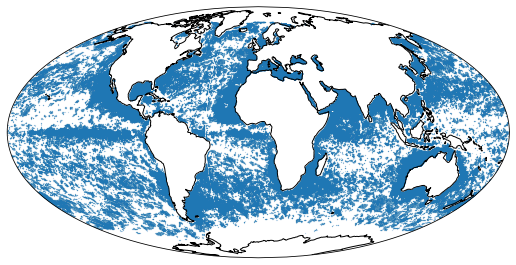

In [146]:
reload(pp_plotting)
pp_plotting.plot_extraction(modis_llc, figsize=(9,6))

## Add in LLC pp_file names

In [154]:
s3_llc_files = np.array(['s3://llc/'+llc_file for llc_file in llc_files])

In [155]:
modis_llc['pp_file'] = s3_llc_files[mt_t[uidx]]

In [156]:
modis_llc[['modis_lat', 'modis_lon', 'lat', 'lon', 'datetime', 'pp_file']].head()

,modis_lat,modis_lon,lat,lon,datetime,pp_file
6828842,-75.63369,176.34877,-75.634514,176.342789,2012-01-10 10:45:00,s3://llc/ThetaUVSalt/LLC4320_2012-01-10T12_00_...
6792033,-75.50313,176.90097,-75.502342,176.904388,2012-01-10 10:45:00,s3://llc/ThetaUVSalt/LLC4320_2012-01-10T12_00_...
7074958,-75.48472,176.05368,-75.486450,176.059402,2012-01-10 10:45:00,s3://llc/ThetaUVSalt/LLC4320_2012-01-10T12_00_...
6853379,-75.30069,177.72563,-75.300201,177.722855,2012-01-10 10:45:00,s3://llc/ThetaUVSalt/LLC4320_2012-01-10T12_00_...
7239974,-75.25666,175.96370,-75.252640,175.969391,2012-01-10 10:45:00,s3://llc/ThetaUVSalt/LLC4320_2012-01-10T12_00_...


## Add in row/col

In [167]:
modis2012_llc['row'] = good_CC_idx[0][idx[uidx]] - field_size[0]//2 # Lower left corner
modis2012_llc['col'] = good_CC_idx[1][idx[uidx]] - field_size[0]//2 # Lower left corner

NameError: name 'llc_table' is not defined

## Write

In [158]:
modis2012_llc = modis_llc.drop(columns=['dt'])

In [159]:
ulmo_io.write_main_table(modis2012_llc, 's3://llc/Tables/modis2012_test.parquet')

Wrote Analysis Table: s3://llc/Tables/modis2012_test.parquet


In [161]:
reload(ulmo_io)
tmp = ulmo_io.load_main_table('s3://llc/Tables/modis2012_test.parquet')

Read main table: s3://llc/Tables/modis2012_test.parquet


In [162]:
tmp.head()

,modis_lat,modis_lon,col,datetime,LL,row,clear_fraction,mean_temperature,Tmin,Tmax,...,UID,pp_file,pp_root,field_size,pp_type,pp_idx,hours,hour_12,lat,lon
6828842,-75.63369,176.34877,389,2012-01-10 10:45:00,218.820679,901,0.049133,0.784100,-0.580,1.800,...,132614366335634877,s3://llc/ThetaUVSalt/LLC4320_2012-01-10T12_00_...,standard,128,0,283192,227,228,-75.634514,176.342789
6792033,-75.50313,176.90097,389,2012-01-10 10:45:00,250.649536,880,0.008484,0.715925,-0.400,1.545,...,132614496935690097,s3://llc/ThetaUVSalt/LLC4320_2012-01-10T12_00_...,standard,128,0,246383,227,228,-75.502342,176.904388
7074958,-75.48472,176.05368,374,2012-01-10 10:45:00,149.231934,896,0.049561,0.833673,-0.580,1.800,...,132614515335605368,s3://llc/ThetaUVSalt/LLC4320_2012-01-10T12_00_...,standard,128,0,529308,227,228,-75.486450,176.059402
6853379,-75.30069,177.72563,389,2012-01-10 10:45:00,197.087646,848,0.006836,0.650087,-0.995,1.445,...,132614699335772563,s3://llc/ThetaUVSalt/LLC4320_2012-01-10T12_00_...,standard,128,0,307729,227,228,-75.300201,177.722855
7239974,-75.25666,175.96370,357,2012-01-10 10:45:00,44.546875,880,0.032532,0.822395,-1.280,1.855,...,132614743335596370,s3://llc/ThetaUVSalt/LLC4320_2012-01-10T12_00_...,standard,128,0,694324,227,228,-75.252640,175.969391
